# Vetorização
O objetivo desta etapa é transpor o texto da descrição da prestação de contas para um vetor numérico multidimensional. Realizaremos uma série de experimentos para definir os melhores hiperparâmetros.

In [1]:
import time
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings, DocumentRNNEmbeddings, Sentence

random_state = 133
sns.set(rc={'figure.figsize':(15,5)})
warnings.filterwarnings(action = 'ignore')
mpl.rcParams['agg.path.chunksize'] = 10000
pd.set_option('display.max_colwidth' , 100)

import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')

stemmer = nltk.stem.RSLPStemmer()
stopwords = nltk.corpus.stopwords.words('portuguese')

Carregar dataframe pre-processado:

In [14]:
df = pd.read_feather('df_preprocessado.feather').set_index('index')
print('dimensão do dataset:', df.shape)

dimensão do dataset: (5598785, 22)


## Preparação

Analisemos a quantidade de instâncias por classe:

In [16]:
df.tipo_despesa_code.value_counts()

29    1280255
31     673951
26     609725
9      553850
4      529345
2      446185
13     328760
3      252382
32     188863
11     157043
23     100744
24      80283
27      74194
20      66062
28      47688
0       38146
18      35291
5       30065
12      18673
19      17545
10      10994
17       9759
6        9620
15       6748
16       6198
25       5447
34       5256
7        4532
33       3356
14       3138
22       1732
1        1208
30        864
8         699
21        184
Name: tipo_despesa_code, dtype: int64

Vamos a seguir balancear o dataset que utilizaremos para definir os hiperparâmetros. O balanceamento é importante para darmos o mesmo peso para as diferentes classes.

In [16]:
g = df[['descricao_despesa', 'tipo_despesa_code']].groupby('tipo_despesa_code')

df_sample = g.apply(lambda x: x.sample(g.size().min(), random_state=random_state).reset_index(drop=True)).reset_index(drop=True)

Dimensão do dataset de experimentos:

In [18]:
df_sample.shape

(6440, 2)

Como ficaram a distribuição das instâncias por classe:

In [19]:
df_sample.tipo_despesa_code.value_counts()

31    184
32    184
21    184
17    184
13    184
9     184
5     184
1     184
28    184
29    184
24    184
20    184
16    184
12    184
8     184
4     184
25    184
33    184
27    184
34    184
23    184
19    184
15    184
11    184
7     184
3     184
30    184
2     184
26    184
22    184
18    184
14    184
10    184
6     184
0     184
Name: tipo_despesa_code, dtype: int64

## TF-IDF
Sigla para Term Frequency-Inverse Document Frequency é uma técnica estatística utilizada para representação vetorial de palavras.

### Escolha dos Melhores Hiperparâmetros
Vamos iniciar a escolha dos hiperparâmetros:

In [16]:
def analisar_qualidade_clusters(X):
    # Utilizaremos os valores por padrão da biblioteca:
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=8, batch_size=100,
                      n_init=3, max_no_improvement=10, verbose=0,
                      random_state = random_state)
    mbk.fit(X)
    inertia = mbk.inertia_
    silhouette = silhouette_score(X, mbk.labels_, sample_size = 1000, random_state = random_state)
    return inertia, silhouette

#### max_features

In [17]:
def analisar_hyper(X, # A seguir são os valores padrões do próprio algoritmo
                    lista_max_features = None,
                    lista_analyzer = ['word'],
                    lista_ngram_range = [(1,1)],
                    lista_max_df = [1.0],
                    lista_min_df = [1]):
    resposta = {}
    df_respostas = pd.DataFrame()
    for t in lista_max_features:
        #print('max_features', t)
        for z in lista_analyzer:
            for w in lista_ngram_range:
                for y in lista_max_df:
                    for q in lista_min_df:
                        tfidf_vectorizer = TfidfVectorizer(max_features = t,
                                                           analyzer = z,
                                                           ngram_range = w,
                                                           max_df = y,
                                                           min_df = q
                                                          )
                        X_tf = tfidf_vectorizer.fit_transform(X)
                        inertia, silhouette = analisar_qualidade_clusters(X_tf)
                        resposta['max_features'] = t
                        resposta['analyzer'] = z
                        resposta['ngram_range'] = w
                        resposta['max_df'] = y
                        resposta['min_df'] = q
                        resposta['inertia'] = inertia
                        resposta['silhouette'] = silhouette

                        df_respostas = df_respostas.append(pd.DataFrame([resposta]), ignore_index = True)
        
    return df_respostas

In [23]:
df_respostas = analisar_hyper(X = df_sample.descricao_despesa.values,
                      lista_max_features = np.arange(1,300, 1))

In [24]:
escalador_inertia = MinMaxScaler()
df_respostas['inertia_mms'] = escalador_inertia.fit_transform(df_respostas[['inertia']].values)
df_respostas_melt = df_respostas[['max_features', 'inertia_mms', 'silhouette']].melt('max_features', var_name='score',  value_name='value')

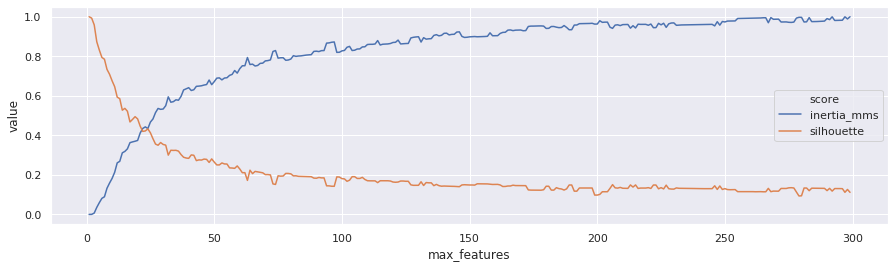

In [25]:
plt.figure(figsize=(15,4))
g = sns.lineplot(x="max_features", y="value", hue='score', data=df_respostas_melt)

Como se percebe no gráfico acima, ao aumentar o número de features temos também um aumento da inércia, prejudicando a qualidade dos clusters. Ou seja, uma menor quantidade de features gera um espaço multimensional com menor inércia. Olhemos em detalhes o gráfico anterior:

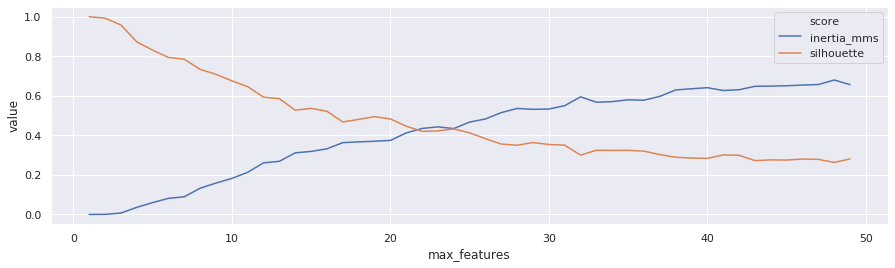

In [26]:
plt.figure(figsize=(15,4))
g = sns.lineplot(x="max_features", y="value", hue='score', data=df_respostas_melt[df_respostas_melt.max_features < 50])

In [27]:
df_respostas[df_respostas.silhouette > 0.5].sort_values(by='silhouette', ascending = True).head(1)

max_features analyzer ngram_range  max_df  min_df      inertia  \
15            16     word      (1, 1)     1.0       1  1612.462476   

    silhouette  inertia_mms  
15    0.522014     0.331728

Vamos escolher o maior max_features com silhouette maior que 0.5, que corresponde ao valor de 16.

#### analyzer e ngram_range

In [74]:
df_respostas = analisar_hyper(X = df_sample.descricao_despesa.values,
                      lista_max_features = [16],
                      lista_analyzer = ['word', 'char', 'char_wb'],
                      lista_ngram_range = [(1,1), (1,2), (1,3), (1,3), (1,4),
                                           (2,2), (2,3), (2,4),
                                           (3,3), (3,4),
                                           (4,4)])

In [75]:
escalador_inertia = MinMaxScaler()
df_respostas['inertia_mms'] = escalador_inertia.fit_transform(df_respostas[['inertia']].values)
df_respostas_melt = df_respostas[['analyzer', 'ngram_range','inertia_mms', 'silhouette']].melt(['analyzer', 'ngram_range'], var_name='score',  value_name='value')

<Figure size 1080x288 with 0 Axes>

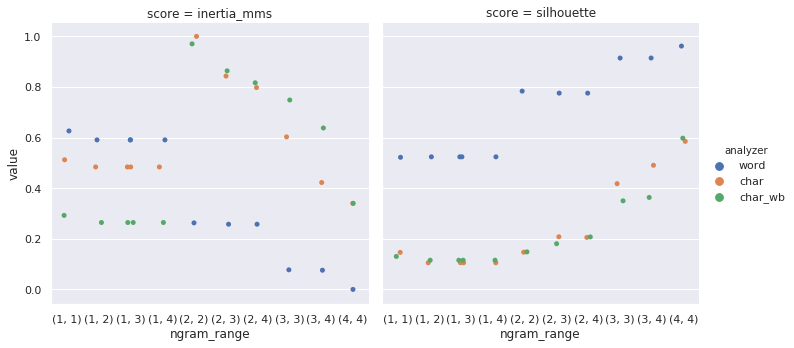

In [76]:
plt.figure(figsize=(15,4))
sns.catplot(x = 'ngram_range', y =  'value',
            hue = 'analyzer', col= 'score',
            data = df_respostas_melt)

In [77]:
df_respostas[df_respostas.silhouette == df_respostas.silhouette.max()]

max_features analyzer ngram_range  max_df  min_df     inertia  silhouette  \
10            16     word      (4, 4)     1.0       1  232.426221    0.961587   

    inertia_mms  
10          0.0

O analyzer __word__ com ngram_range igual a (4,4) obteve a melhor silhouette.

In [78]:
analisar_hyper(X = df_sample.descricao_despesa.values,
                      lista_max_features = [16],
                      lista_analyzer = ['word'],
                      lista_ngram_range = [(4,4)])

max_features analyzer ngram_range  max_df  min_df     inertia  silhouette
0            16     word      (4, 4)     1.0       1  232.426221    0.961587

### Represenção em 2D
Com os melhores hiperparâmetros segundo silhouette, aplicaremos configurações escolhidas para visualizarmos em 2D.

In [22]:
def representar_2D (X, plotar_grafico = True):
    n_clusters = 8
    # #############################################################################
    # Compute clustering with MiniBatchKMeans

    mbk = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=100,
                          n_init=3, max_no_improvement=10, verbose=0,
                          random_state = random_state)            
            
    t0 = time.time()
    mbk.fit(X)
    t_mini_batch = time.time() - t0
    
    trunc = PCA(n_components=2, random_state=random_state)
    try:
        X_trunc = trunc.fit_transform(X.todense())
    except:
        X_trunc = trunc.fit_transform(X)
        
    silhouette = silhouette_score(X, mbk.labels_, sample_size = 1000, random_state = random_state)

    df_X_trunc = pd.DataFrame(X_trunc, columns=["x", "y"])
    df_X_trunc['label'] = mbk.labels_
    df_X_trunc.label = df_X_trunc.label.astype(str) #.str.slice(stop=3)
    # #############################################################################
    # Plot result
    fig, ax = plt.subplots(figsize=(15, 4))
    print ('train time: %.2fs\ninertia: %.2f\nsilhouette: %.4f' %
             (t_mini_batch, mbk.inertia_, silhouette))
    
    if plotar_grafico:
        sns.scatterplot('x', 'y', hue = 'label', data=df_X_trunc, palette=sns.color_palette("Set2", n_clusters))
        ax.set_title('MiniBatchKMeans')
        ax.set_xticks(())
        ax.set_yticks(())

        plt.show()
    return df_X_trunc

Vamos visualizar com ngram (3,4):

(5598785, 16)
train time: 11.51s
inertia: 323760.12
silhouette: 0.8756


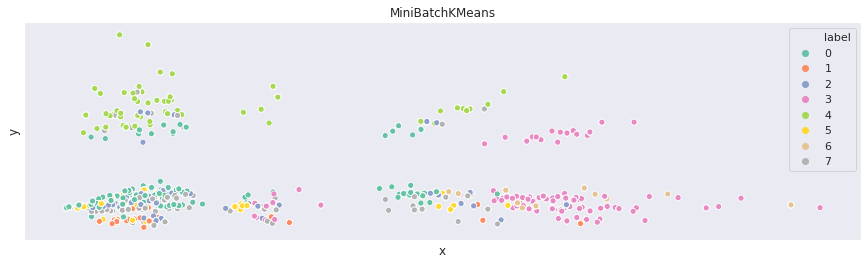

In [23]:
tfidf_vectorizer = TfidfVectorizer(max_features=16,
                                   analyzer = 'word',
                                   ngram_range = (3,4))
tfidf_matrix = tfidf_vectorizer.fit_transform(df.descricao_despesa.values)

print(tfidf_matrix.shape)
df_resultado = representar_2D(X = tfidf_matrix)

Vamos analisar o ponto na extrema direita:

In [42]:
df_resultado[df_resultado.x == df_resultado.x.max()]

x         y label
3015267  0.900026 -0.053805     3
3236528  0.900026 -0.053805     3

In [38]:
df.descricao_despesa.loc[3015267]

'prestação de serviços de assessoria jurídica na elaboração da prestação de serviços durante a campan'

Descrição parece bem normal.

Vamos visualizar com ngram (4,4):

train time: 12.14s
inertia: 192115.21
silhouette: 0.9355


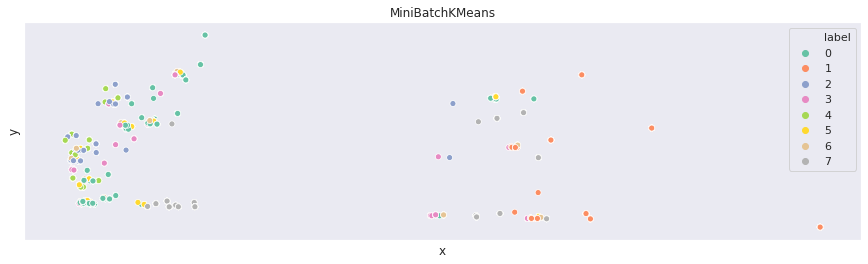

In [43]:
tfidf_vectorizer = TfidfVectorizer(max_features=16,
                                   analyzer = 'word',
                                   ngram_range = (4,4))
tfidf_matrix = tfidf_vectorizer.fit_transform(df.descricao_despesa.values)

df_resultado = representar_2D(X = tfidf_matrix, Y = df.tipo_despesa_code.values)

In [50]:
df_resultado[df_resultado.x == df_resultado.x.max()].sample(5, random_state = random_state)

x         y label
1400300  0.957928 -0.149046     1
1636606  0.957928 -0.149046     1
4545137  0.957928 -0.149046     1
76756    0.957928 -0.149046     1
5425955  0.957928 -0.149046     1

Vamos verificar a descrição destas amostras:

In [52]:
for t in df_resultado[df_resultado.x == df_resultado.x.max()].sample(5, random_state = random_state).index:
    print (df.descricao_despesa.loc[t])

prestação de serviços de panfletagem no período de 14 a 16/09/2016
prestação de serviços de auxiliar de serviços gerais· eleição 2016 - 26/09 a 01/10
prestação de serviços de natureza eleitoral ao candidato 8hs/dia
prestação de serviços de organização e estratégia de campanha eleitoral 2016
prestação de serviços de consultoria juridica eleições 2016


Vamos ver a quantidade de despesas neste ponto do espaço 2D:

In [55]:
df_resultado[df_resultado.x == df_resultado.x.max()].shape[0]

55894

Ou seja, temos 55.894 registros neste ponto do espaço, logo não podemos considerar anomalia pois existe uma densidade alta de ocorrências neste ponto.

Observe que neste momento estamos analisando a representação 2D de um espaço de 16 dimensões. Num momento à frente faremos uma análise mais completa considerando todo o espaço multidimensional.

Sem ngram_range:

(5598785, 16)
train time: 40.89s
inertia: 1318002.64
silhouette: 0.5423


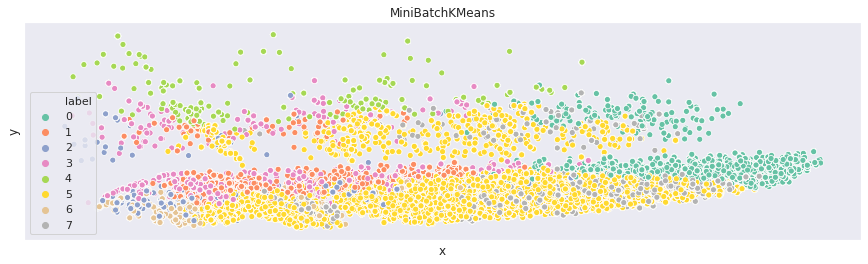

In [108]:
tfidf_vectorizer = TfidfVectorizer(max_features=16,
                                   analyzer = 'word')
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in df['descricao_despesa']])

print(tfidf_matrix.shape)

_ = representar_2D(X = tfidf_matrix, Y = df.tipo_despesa_code.values)

#### Versão com melhores hiperparâmetros
Utilizando como referência a melhor silhouette, os hiperparâmetros escolhidos foram:
- __max_features:__ 16;
- __analyzer:__ word;
- __ngram_range:__ (4,4)

Contudo, na etapa de análise, a configuração mais interessante foi sem a opção ngrams.

### Melhoria Corpus
Apesar do ngram_rage (4,4) ter alcançado um excelente silhouette, para a escolha das melhores otimizações do corpus utilizaremos apenas a max_features de 16 e analyzer word, para visualizarmos o quanto melhora.
#### Baseline

train time: 0.05s
inertia: 1612.46
silhouette: 0.5220


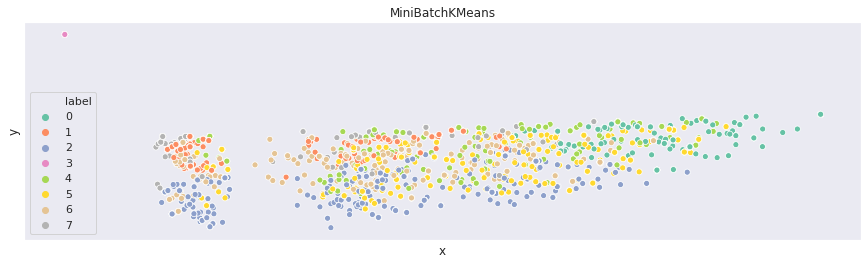

In [56]:
tfidf_matrix = TfidfVectorizer(max_features=16,
                               analyzer = 'word').fit_transform([x for x in df_sample['descricao_despesa']])

_ = representar_2D(X = tfidf_matrix)

### Remover Pontuação

train time: 0.06s
inertia: 1612.46
silhouette: 0.5220


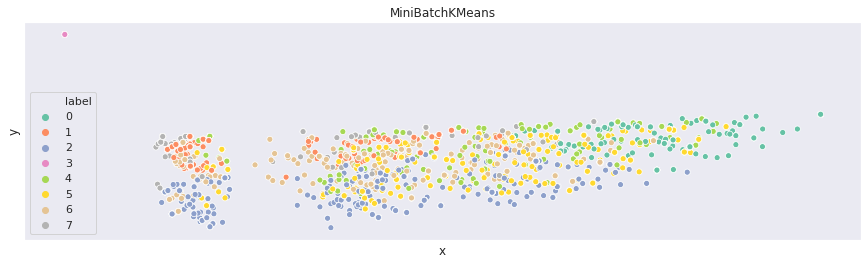

In [24]:
df_sample['descricao_despesa_semPont'] = df_sample.descricao_despesa.str.replace('[^\w\s]',' ')
tfidf_matrix = TfidfVectorizer(max_features=16,
                                   analyzer = 'word').fit_transform([x for x in df_sample['descricao_despesa_semPont']])
_ = representar_2D(X = tfidf_matrix)

Não houve alteração da silhouette.

### remover stopwords

In [112]:
df_sample['descricao_despesa_stop'] = df_sample['descricao_despesa'].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords]))
tfidf_matrix = TfidfVectorizer(max_features=16,
                                   analyzer = 'word').fit_transform([x for x in df_sample['descricao_despesa_stop']])
print(tfidf_matrix.shape)

(6440, 16)


train time: 0.06s
inertia: 1398.34
silhouette: 0.6056


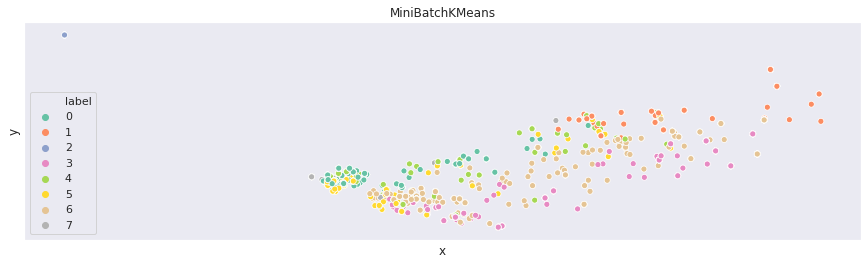

In [114]:
_ = representar_2D(X = tfidf_matrix)

Removendo stopwords tanto a inércia quanto a silhouette melhoraram.

### Remover dígitos
Nesta etapa removeremos todos os números do corpus e verificar se houve melhora na vetorização.

In [115]:
df_sample['descricao_despesa_stop_sdig'] = df_sample['descricao_despesa_stop'].str.replace('\d+', '')
tfidf_matrix = TfidfVectorizer(max_features=16,
                               analyzer = 'word').fit_transform([x for x in df_sample['descricao_despesa_stop_sdig']])
print(tfidf_matrix.shape)

(6440, 16)


In [116]:
inertia, silhouette = analisar_qualidade_clusters(tfidf_matrix)
print ('[ inertia =', inertia, '][ silhouette =', silhouette, ']')

[ inertia = 1410.2128999826036 ][ silhouette = 0.6233489771413679 ]


train time: 0.06s
inertia: 1410.21
silhouette: 0.6233


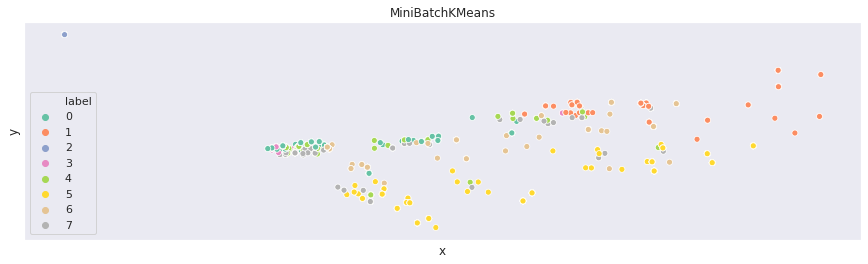

In [117]:
_ = representar_2D(X = tfidf_matrix)

Removendo dígitos a inércia piorou e a silhouette melhorou.

### Remover Palavras Pequenas 
Removeremos nesta etapa palabras que tenham apenas 1 caractere.

In [118]:
df_sample['descricao_despesa_stop_sdig_n1'] = df_sample['descricao_despesa_stop_sdig'].apply(lambda x: ' '.join(word for word in x.split() if len(word)>1))
tfidf_matrix = TfidfVectorizer(max_features=16,
                               analyzer = 'word').fit_transform([x for x in df_sample['descricao_despesa_stop_sdig_n1']])
print(tfidf_matrix.shape)

(6440, 16)


In [119]:
inertia, silhouette = analisar_qualidade_clusters(tfidf_matrix)
print ('[ inertia =', inertia, '][ silhouette =', silhouette, ']')

[ inertia = 1410.2128999826036 ][ silhouette = 0.6233489771413679 ]


train time: 0.07s
inertia: 1410.21
silhouette: 0.6233


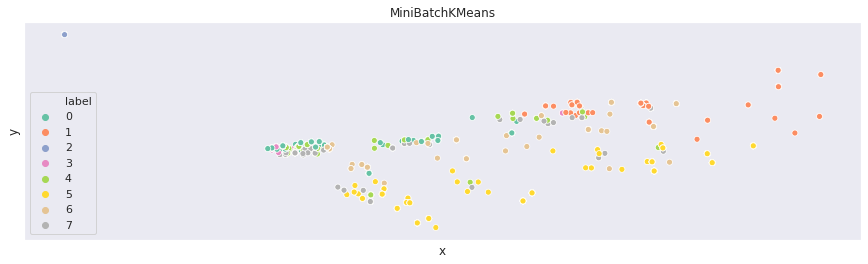

In [120]:
_ = representar_2D(X = tfidf_matrix)

Removendo pequenas palavras a inércia e o silhouette se mantiveram iguais.

### Versão com descrição escolhida
Vamos trabalhar agora com a descrição das prestações utilizando as alterações que percebemos melhora na acurácia.

In [101]:
df['descricao_despesa_otimo'] = df['descricao_despesa'].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords]))
df['descricao_despesa_otimo'] = df['descricao_despesa_otimo'].str.replace('\d+', '')

Parâmetros escolhidos para o TF-IDF:
- max_features = __16__;
- analyzer = __word__;
- ngram_range = __(4,4)__.

In [124]:
tfidf_matrix = TfidfVectorizer(max_features=16,
                               analyzer = 'word',
                               ngram_range = (4,4)
                              ).fit_transform([x for x in df['descricao_despesa_otimo']])
pickle.dump(tfidf_matrix, open("tfidf_matrix_corpusOtimo_bestSilh_maxFeat16_analyzerWord_ngram44.pickle", "wb"))

Para a etapa de clusterização e análise também utilizaremos a seguinte configuração:
- max_features = __16__;
- analyzer = __word__;

In [122]:
tfidf_matrix = TfidfVectorizer(max_features=16,
                               analyzer = 'word').fit_transform([x for x in df['descricao_despesa_otimo']])
pickle.dump(tfidf_matrix, open("tfidf_matrix_corpusOtimo_maxFeat16_analyzerWord.pickle", "wb"))

## Flair
Vamos utilizar nesta etapa uma outra abordagem de vetorização de texto, utilizando a biblioteca __flair__ [2].

In [ ]:
glove_embedding = WordEmbeddings('pt') #qual o corpus?

In [ ]:
def createMatrix(data, doc_embeddings):
    data_flair_matrix = []
    for x in data:
        sentence = Sentence(x)
        doc_embeddings.embed(sentence)
        data_flair_matrix.append(sentence.get_embedding().detach().numpy())
        
    data_flair_matrix = np.asarray([t for t in data_flair_matrix])
    data_flair_matrix.shape
    data_flair_matrix = MinMaxScaler().fit_transform(data_flair_matrix)
    return data_flair_matrix

### DocumentPoolEmbeddings

train time: 0.08s
inertia: 12289.59
silhouette: 0.0302


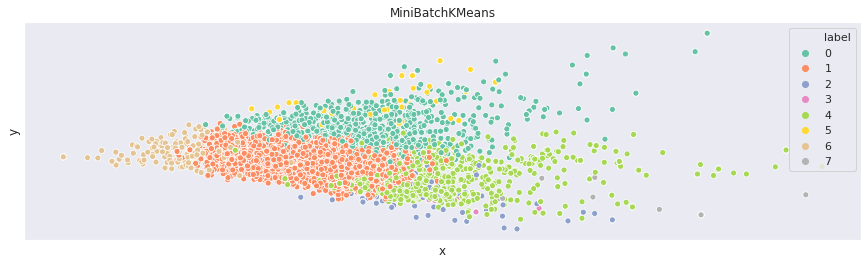

In [27]:
document_embeddings = DocumentPoolEmbeddings([glove_embedding])

flair_matrix = createMatrix(df_sample.descricao_despesa.values, document_embeddings)

_ = representar_2D(X = flair_matrix)

#### forward e backward

In [ ]:
# initialize the word embeddings
flair_embedding_forward = FlairEmbeddings('pt-forward')
flair_embedding_backward = FlairEmbeddings('pt-backward')

In [20]:
document_embeddings = DocumentPoolEmbeddings([glove_embedding,
                                              flair_embedding_backward,
                                              flair_embedding_forward])

In [30]:
flair_matrix = createMatrix(df_sample.descricao_despesa.values, document_embeddings)

train time: 0.40s
inertia: 94534.32
silhouette: 0.0768


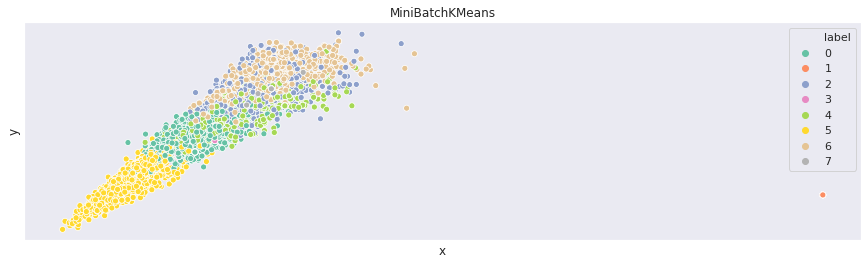

In [31]:
_ = representar_2D(X = flair_matrix)

#### Max Pooling

train time: 0.58s
inertia: 128514.77
silhouette: 0.0849


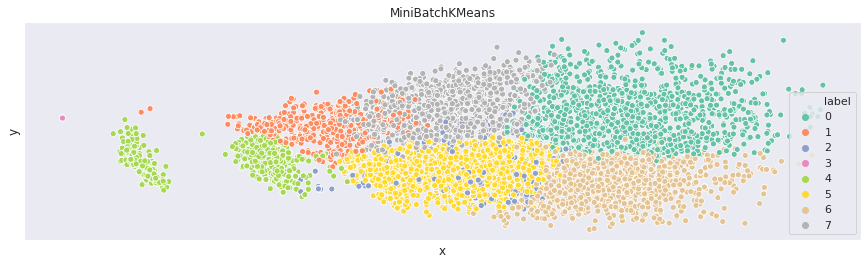

In [32]:
document_embeddings = DocumentPoolEmbeddings([glove_embedding,
                                              flair_embedding_backward,
                                              flair_embedding_forward],
                                            pooling='max')

flair_matrix = createMatrix(df_sample.descricao_despesa.values, document_embeddings)

_ = representar_2D(X = flair_matrix)

#### Min Pooling

train time: 1.25s
inertia: 126332.19
silhouette: 0.0919


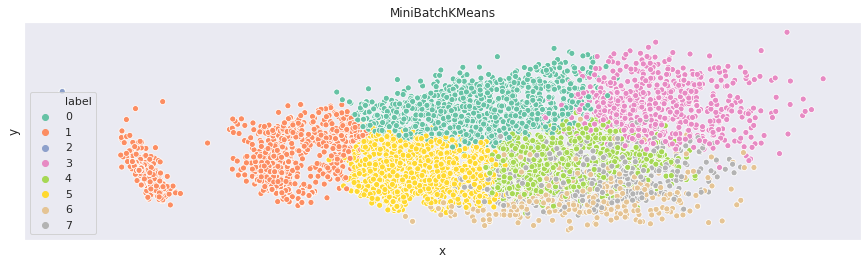

In [24]:
document_embeddings = DocumentPoolEmbeddings([glove_embedding,
                                              flair_embedding_backward,
                                              flair_embedding_forward],
                                            pooling='min')

flair_matrix = createMatrix(df_sample.descricao_despesa.values, document_embeddings)

_ = representar_2D(X = flair_matrix)

#### Non Linear

train time: 0.16s
inertia: 12353.54
silhouette: 0.0855


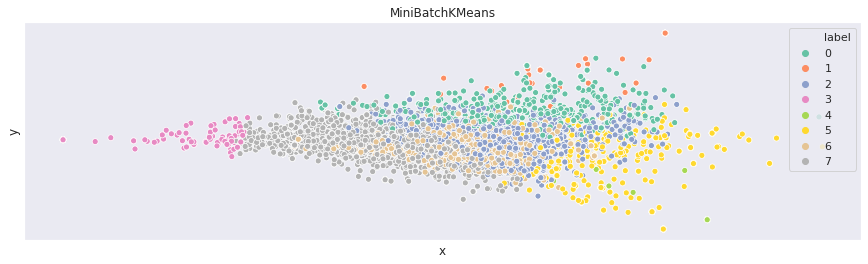

In [34]:
document_embeddings = DocumentPoolEmbeddings([glove_embedding], fine_tune_mode='nonlinear')

flair_matrix = createMatrix(df_sample.descricao_despesa.values, document_embeddings)

_ = representar_2D(X = flair_matrix)

#### None fine tune

train time: 0.15s
inertia: 12289.59
silhouette: 0.0302


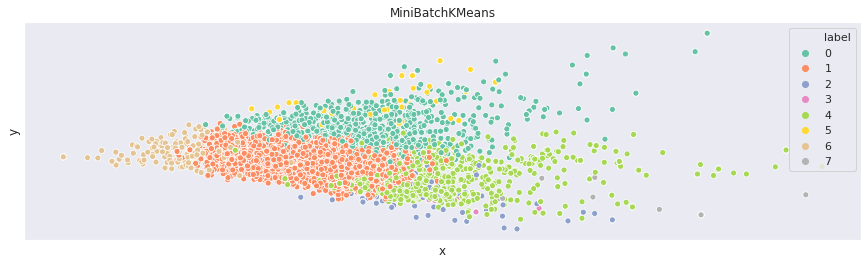

In [35]:
document_embeddings = DocumentPoolEmbeddings([glove_embedding], fine_tune_mode='none')

flair_matrix = createMatrix(df_sample.descricao_despesa.values, document_embeddings)

_ = representar_2D(X = flair_matrix)

### DocumentRNNEmbeddings

In [36]:
document_embeddings = DocumentRNNEmbeddings([glove_embedding])

flair_matrix = createMatrix(df_sample.descricao_despesa.values, document_embeddings)

_ = representar_2D(X = flair_matrix)

train time: 0.22s
inertia: 9218.03
silhouette: 0.1424


#### LSTM

In [25]:
document_embeddings = DocumentRNNEmbeddings([glove_embedding], rnn_type='LSTM')

flair_matrix = createMatrix(df_sample.descricao_despesa.values, document_embeddings)

_ = representar_2D(X = flair_matrix)

train time: 0.56s
inertia: 8778.85
silhouette: 0.1446


### Modo Flair escolhido
Considerando apenas a silhouette, a melhor configuração que obtivemos ao rodar o Flair foi utilizando RNN com LSTM. O que vamos fazer a seguir é verificar se podemos melhorar ainda mais o score trabalhando o texto de entrada.

In [22]:
document_embeddings = DocumentRNNEmbeddings([glove_embedding], rnn_type='LSTM')

#### Remover Stopwords

In [41]:
df_sample['descricao_despesa_semPont_stop'] = df_sample['descricao_despesa_semPont'].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords]))

flair_matrix = createMatrix(df_sample.descricao_despesa_semPont_stop.values, document_embeddings)

_ = representar_2D(X = flair_matrix)

train time: 0.23s
inertia: 10344.52
silhouette: 0.1391


O Silhouette piorou.

#### Remover espaços adicionais

train time: 0.19s
inertia: 10233.37
silhouette: 0.1666


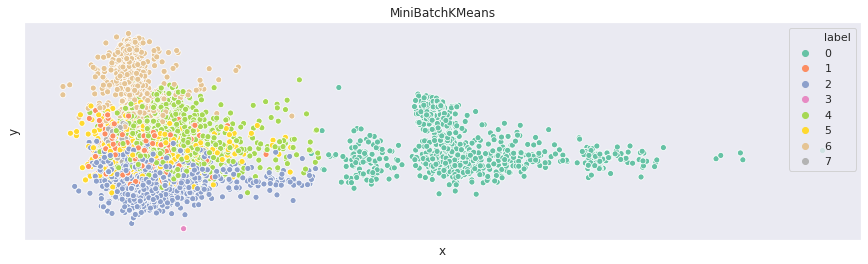

In [46]:
df_sample['descricao_despesa_semPont_n1_strip'] = df_sample['descricao_despesa_semPont_n1'].str.strip()
df_sample['descricao_despesa_semPont_n1_strip'] = df_sample['descricao_despesa_semPont_n1_strip'].replace('\s+', ' ', regex=True)

flair_matrix = createMatrix(df_sample.descricao_despesa_semPont_n1_strip.values, document_embeddings)

_ = representar_2D(X = flair_matrix)

A silhouette se manteve.
#### Stemmer
A seguir temos um passo importantepara a mineração de textos, iremos reduzir as palavras para sua haste principal, ou seja, o radical. Para isto são removidos os afixos morfológicos presentes na palavra.

train time: 0.18s
inertia: 8278.54
silhouette: 0.2431


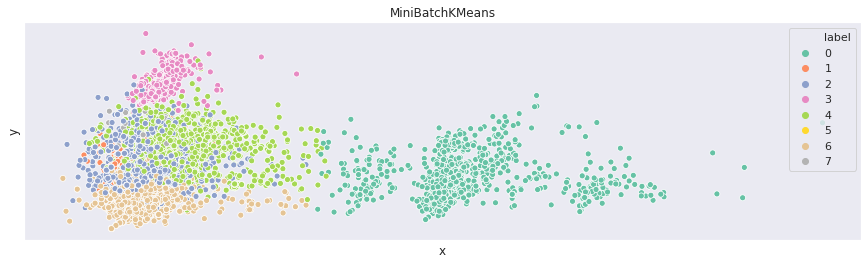

In [48]:
df_sample['descricao_despesa_semPont_n1_tok'] = df_sample.descricao_despesa_semPont_n1.apply(nltk.word_tokenize)
df_sample['descricao_despesa_semPont_n1_tok'] = df_sample['descricao_despesa_semPont_n1_tok'].apply(lambda x: [stemmer.stem(y) for y in x])
df_sample['descricao_despesa_semPont_n1_tok'] = df_sample['descricao_despesa_semPont_n1_tok'].str.join(' ')

flair_matrix = createMatrix(df_sample.descricao_despesa_semPont_n1_tok.values, document_embeddings)

_ = representar_2D(X = flair_matrix)

A silhouette melhorou.

### Aplicar alterações em todo o dataset
Iremos agora aplicar as alterações que obtiveram os melhores resultados com o Flair, que foram:

- Stemmer;

In [ ]:
df['descricao_despesa_otimizado_flair'] = df.descricao_despesa.apply(nltk.word_tokenize)
df['descricao_despesa_otimizado_flair'] = df['descricao_despesa_otimizado_flair'].apply(lambda x: [stemmer.stem(y) for y in x])
df['descricao_despesa_otimizado_flair'] = df['descricao_despesa_otimizado_flair'].str.join(' ')

## Vetorizar Todo Dataset
Vetorizar todo o dataset com os melhores parâmetros encontrados: 


In [ ]:
flair_matrix = createMatrix(df.descricao_despesa_otimizado_flair.values, document_embeddings)

In [ ]:
pickle.dump(flair_matrix, open("flair_matrix_corpusOtimo_bestSilh_LSTM.pickle", "wb"))

Vamos salvar também uma versão com RNN:

In [ ]:
document_embeddings = DocumentRNNEmbeddings([glove_embedding])
flair_matrix = createMatrix(df.descricao_despesa_otimizado_flair.values, document_embeddings)

In [26]:
pickle.dump(flair_matrix, open("flair_matrix_corpusOtimo_RNN.pickle", "wb"))

# Referências
- [1] Freediscovery. Acessado em 23/07/2020: http://freediscovery.io/doc/stable/python/examples/optimize_tfidf.html
- [2] Flair. Acessado em 23/07/2020: https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_5_DOCUMENT_EMBEDDINGS.md